### Day 3: Load and explore data

In [156]:
import pandas as pd

df = pd.read_csv("C:/Users/yb017/Desktop/Badminton_risk_proj/data/bookings.csv")
df.head()
df.info()
df[["booked_courts", "total_courts", "utilisation"]].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   venue          2400 non-null   object 
 1   date           2400 non-null   object 
 2   day_of_week    2400 non-null   object 
 3   hour           2400 non-null   int64  
 4   total_courts   2400 non-null   int64  
 5   booked_courts  2400 non-null   int64  
 6   utilisation    2400 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 131.4+ KB


,booked_courts,total_courts,utilisation
0,2,6,0.3
1,2,6,0.4
2,2,6,0.3
3,1,6,0.2
4,2,6,0.4


In [157]:
# Finding demand pattern: Average bookings by hour
avg_by_hour = (
    df 
    .groupby("hour")["booked_courts"] # group booked courts by hour 
    .mean() # avg num of booked courts within each time slot 
    .reset_index()
)
avg_by_hour.sort_values("booked_courts", ascending = False) # descending

# The peak hours for badminton court bookings are 18-19, 19-20, 20-21

,hour,booked_courts
11,18,3.786667
12,19,3.780000
13,20,3.620000
15,22,1.826667
5,12,1.813333
7,14,1.806667
9,16,1.800000
1,8,1.786667
2,9,1.780000
3,10,1.746667


In [158]:
# Finding the time slot with the highest utilisation
util_by_hour = (
    df
    .groupby("hour")["utilisation"]
    .mean()
    .reset_index()
)
util_by_hour.sort_values("utilisation", ascending = False)

# The highest utilisation occurs at hour 19-20

,hour,utilisation
12,19,0.758667
11,18,0.748667
13,20,0.736000
15,22,0.364000
1,8,0.361333
3,10,0.354000
5,12,0.353333
2,9,0.351333
7,14,0.351333
9,16,0.350000


In [159]:
# Finding the most capacity constrained venues
venue_util = (
    df
    .groupby("venue") # group by venue
    .agg( # calculating multiple statistics, for each group (venue)
        avg_utilisation = ("utilisation", "mean"), # calculating mean
        avg_booked = ("booked_courts", "mean"),
        total_courts = ("total_courts", "mean")
    )
.reset_index()
)
venue_util.sort_values("avg_utilisation", ascending = False)

# The most capacity constrained venue is USC hall, with an average utilisation of 0.427

,venue,avg_utilisation,avg_booked,total_courts
3,USC Hall,0.427292,2.570833,6.0
0,Kent Ridge Hall,0.425417,1.250000,3.0
1,MPSH 1,0.423542,1.727083,4.0
4,UTown Sports Hall,0.421458,3.379167,8.0
2,MPSH 2,0.416042,1.675000,4.0


In [160]:
# Utilisation on weekdays vs weekends
df["is_weekend"] = df["day_of_week"].isin(["Saturday", "Sunday"]) # True or False
weekday_vs_weekend = (
    df
    .groupby("is_weekend")["utilisation"]
    .mean()
    .reset_index()
)
weekday_vs_weekend

# weekend utilisation is higher compared to weekdays, suggesting that demand relative to available capacity is higher on weekends.

,is_weekend,utilisation
0,False,0.371364
1,True,0.564063


### Day 4: Availability Search Logic
- Filters by date and hour, only showing venues with available courts 
- Ranks options by utilisation to minimize the risk of booking failure

In [161]:
def search_available(date, hour):
    filtered = df[
        (df["date"] == date) & # match by date and hour
        (df["hour"] == hour)
    ].copy()

    filtered["available_courts"] = ( #create new column
        filtered["total_courts"] - filtered["booked_courts"]
    )

    feasible = filtered[filtered["available_courts"] > 0] 
    # available only if available courts > 0 

    result = (
        feasible
        .sort_values("utilisation") # sort by utilisation 
        [["venue", "available_courts", "utilisation"]] # show only 3 columns 
    )

    return result

In [162]:
# Tests
from IPython.display import display
display(search_available("2026-01-10", 18))
display(search_available("2026-01-10", 19))
display(search_available("2026-01-11", 20))

,venue,available_courts,utilisation
747,MPSH 1,1,0.8
267,USC Hall,1,0.9
1707,UTown Sports Hall,1,0.9


,venue,available_courts,utilisation
748,MPSH 1,1,0.7
2188,Kent Ridge Hall,1,0.8
1708,UTown Sports Hall,1,0.9


,venue,available_courts,utilisation
765,MPSH 1,1,0.8
1245,MPSH 2,1,0.8


### Day 5: Risk Scoring 
- Convert utilisation and other factors into a risk score
- Classify booking risk levels

In [163]:
peak_hours = [18, 19, 20]
df["peak_hour_flag"] = df["hour"].isin(peak_hours).astype(int)
df["weekend_flag"] = df["is_weekend"].astype(int)

df["risk_score"] = ( # each factor carries a different weight in the score
    0.5 * df["utilisation"] +
    0.3 * df["peak_hour_flag"] +
    0.2 * df["weekend_flag"]
)
df.head()

,venue,date,day_of_week,hour,total_courts,booked_courts,utilisation,is_weekend,peak_hour_flag,weekend_flag,risk_score
0,USC Hall,2025-12-25,Thursday,7,6,2,0.3,False,0,0,0.15
1,USC Hall,2025-12-25,Thursday,8,6,2,0.4,False,0,0,0.20
2,USC Hall,2025-12-25,Thursday,9,6,2,0.3,False,0,0,0.15
3,USC Hall,2025-12-25,Thursday,10,6,1,0.2,False,0,0,0.10
4,USC Hall,2025-12-25,Thursday,11,6,2,0.4,False,0,0,0.20


In [164]:
def classify_risk(score):
    if score < 0.4: # if lower than 0.4
        return "Low"
    elif score <= 0.7: # if 0.4 <= score <= 0.7
        return "Medium"
    else: # higher than 0.7
        return "High"
df["risk_level"] = df["risk_score"].apply(classify_risk) # apply fn
df["risk_level"].value_counts()

# We observe that the most rows have low risk level, followed by medium then high

risk_level
Low       1512
Medium     731
High       157
Name: count, dtype: int64

In [165]:
# Test for peak hour and non-peak hour

df[
    (df["hour"] == 19) &
    (df["weekend_flag"] == 1)
][["venue", "utilisation", "risk_score", "risk_level"]].head()

df[
    (df["hour"] == 10) &
    (df["weekend_flag"] == 0)
][["venue", "utilisation", "risk_score", "risk_level"]].head()

,venue,utilisation,risk_score,risk_level
3,USC Hall,0.2,0.1,Low
19,USC Hall,0.2,0.1,Low
67,USC Hall,0.4,0.2,Low
83,USC Hall,0.2,0.1,Low
99,USC Hall,0.2,0.1,Low


In [166]:
# Updated search_available function should sort by risk_score instead of utilisation]

def search_available(date, hour):
    filtered = df[
        (df["date"] == date) & # match by date and hour
        (df["hour"] == hour)
    ].copy()

    filtered["available_courts"] = ( #create new column
        filtered["total_courts"] - filtered["booked_courts"]
    )

    feasible = filtered[filtered["available_courts"] > 0] 
    # available only if available courts > 0 

    result = (
        feasible
        .sort_values("risk_score") # sort by risk_score 
        [["venue", "available_courts", "risk_score", "risk_level"]] # show only 3 columns 
    )

    return result

# Tests
from IPython.display import display
display(search_available("2026-01-10", 18))
display(search_available("2025-12-29", 10))
display(search_available("2026-01-15", 19))

,venue,available_courts,risk_score,risk_level
747,MPSH 1,1,0.90,High
267,USC Hall,1,0.95,High
1707,UTown Sports Hall,1,0.95,High


,venue,available_courts,risk_score,risk_level
547,MPSH 1,3,0.10,Low
1507,UTown Sports Hall,6,0.15,Low
67,USC Hall,3,0.20,Low
1027,MPSH 2,3,0.20,Low
1987,Kent Ridge Hall,2,0.25,Low


,venue,available_courts,risk_score,risk_level
2268,Kent Ridge Hall,1,0.55,Medium
348,USC Hall,1,0.70,Medium
828,MPSH 1,1,0.70,Medium
1788,UTown Sports Hall,2,0.70,Medium


### Day 6: Scenario and stress testing

In [167]:
def apply_scenario(df, demand_shock = 0.0, court_loss = 0):
    # demand_shock and court_loss = 0 by default, if not specified
    stressed = df.copy() # make copy of df 

    stressed["stressed_demand"] = ( # stress demand 
        stressed["booked_courts"] * (1+demand_shock) # percentage increase 
    ).round().astype(int)

    stressed["stressed_capacity"] = ( # stress capacity
        stressed["total_courts"] - court_loss
    ).clip(lower = 1) # lowest value is 1 (lower than 1 becomes 1)

    stressed["stressed_utilisation"] = ( # new utilisation
        stressed["stressed_demand"] / stressed["stressed_capacity"]
    ).round(1)

    stressed["stressed_rs"] = ( # new risk score
        0.5*stressed["stressed_utilisation"] + 
        0.3*stressed["peak_hour_flag"] + 
        0.2*stressed["weekend_flag"]
    ).round(2)

    stressed["stressed_rl"] = ( # new risk level
        stressed["stressed_rs"].apply(classify_risk)
    )

    return stressed

In [168]:
base = df.copy()

# 3 scenarios
increase_demand = apply_scenario(df, demand_shock=0.2, court_loss=0)
decrease_capacity = apply_scenario(df, demand_shock=0.0, court_loss=1)
combined = apply_scenario(df, demand_shock=0.2, court_loss=1)

display(increase_demand)
display(decrease_capacity)
display(combined)

,venue,date,day_of_week,hour,total_courts,booked_courts,utilisation,is_weekend,peak_hour_flag,weekend_flag,risk_score,risk_level,stressed_demand,stressed_capacity,stressed_utilisation,stressed_rs,stressed_rl
0,USC Hall,2025-12-25,Thursday,7,6,2,0.3,False,0,0,0.15,Low,2,6,0.3,0.15,Low
1,USC Hall,2025-12-25,Thursday,8,6,2,0.4,False,0,0,0.20,Low,2,6,0.3,0.15,Low
2,USC Hall,2025-12-25,Thursday,9,6,2,0.3,False,0,0,0.15,Low,2,6,0.3,0.15,Low
3,USC Hall,2025-12-25,Thursday,10,6,1,0.2,False,0,0,0.10,Low,1,6,0.2,0.10,Low
4,USC Hall,2025-12-25,Thursday,11,6,2,0.4,False,0,0,0.20,Low,2,6,0.3,0.15,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,Kent Ridge Hall,2026-01-23,Friday,18,3,2,0.7,False,1,0,0.65,Medium,2,3,0.7,0.65,Medium
2396,Kent Ridge Hall,2026-01-23,Friday,19,3,2,0.6,False,1,0,0.60,Medium,2,3,0.7,0.65,Medium
2397,Kent Ridge Hall,2026-01-23,Friday,20,3,2,0.8,False,1,0,0.70,Medium,2,3,0.7,0.65,Medium
2398,Kent Ridge Hall,2026-01-23,Friday,21,3,1,0.4,False,0,0,0.20,Low,1,3,0.3,0.15,Low


,venue,date,day_of_week,hour,total_courts,booked_courts,utilisation,is_weekend,peak_hour_flag,weekend_flag,risk_score,risk_level,stressed_demand,stressed_capacity,stressed_utilisation,stressed_rs,stressed_rl
0,USC Hall,2025-12-25,Thursday,7,6,2,0.3,False,0,0,0.15,Low,2,5,0.4,0.20,Low
1,USC Hall,2025-12-25,Thursday,8,6,2,0.4,False,0,0,0.20,Low,2,5,0.4,0.20,Low
2,USC Hall,2025-12-25,Thursday,9,6,2,0.3,False,0,0,0.15,Low,2,5,0.4,0.20,Low
3,USC Hall,2025-12-25,Thursday,10,6,1,0.2,False,0,0,0.10,Low,1,5,0.2,0.10,Low
4,USC Hall,2025-12-25,Thursday,11,6,2,0.4,False,0,0,0.20,Low,2,5,0.4,0.20,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,Kent Ridge Hall,2026-01-23,Friday,18,3,2,0.7,False,1,0,0.65,Medium,2,2,1.0,0.80,High
2396,Kent Ridge Hall,2026-01-23,Friday,19,3,2,0.6,False,1,0,0.60,Medium,2,2,1.0,0.80,High
2397,Kent Ridge Hall,2026-01-23,Friday,20,3,2,0.8,False,1,0,0.70,Medium,2,2,1.0,0.80,High
2398,Kent Ridge Hall,2026-01-23,Friday,21,3,1,0.4,False,0,0,0.20,Low,1,2,0.5,0.25,Low


,venue,date,day_of_week,hour,total_courts,booked_courts,utilisation,is_weekend,peak_hour_flag,weekend_flag,risk_score,risk_level,stressed_demand,stressed_capacity,stressed_utilisation,stressed_rs,stressed_rl
0,USC Hall,2025-12-25,Thursday,7,6,2,0.3,False,0,0,0.15,Low,2,5,0.4,0.20,Low
1,USC Hall,2025-12-25,Thursday,8,6,2,0.4,False,0,0,0.20,Low,2,5,0.4,0.20,Low
2,USC Hall,2025-12-25,Thursday,9,6,2,0.3,False,0,0,0.15,Low,2,5,0.4,0.20,Low
3,USC Hall,2025-12-25,Thursday,10,6,1,0.2,False,0,0,0.10,Low,1,5,0.2,0.10,Low
4,USC Hall,2025-12-25,Thursday,11,6,2,0.4,False,0,0,0.20,Low,2,5,0.4,0.20,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,Kent Ridge Hall,2026-01-23,Friday,18,3,2,0.7,False,1,0,0.65,Medium,2,2,1.0,0.80,High
2396,Kent Ridge Hall,2026-01-23,Friday,19,3,2,0.6,False,1,0,0.60,Medium,2,2,1.0,0.80,High
2397,Kent Ridge Hall,2026-01-23,Friday,20,3,2,0.8,False,1,0,0.70,Medium,2,2,1.0,0.80,High
2398,Kent Ridge Hall,2026-01-23,Friday,21,3,1,0.4,False,0,0,0.20,Low,1,2,0.5,0.25,Low


In [169]:
# Comparing risk levels before vs after 
pd.crosstab(
    base["risk_level"],
    combined["stressed_rl"],
    normalize = "index" # each row is converted into proportions that sum to 1 (100%)
)

# LHS column = previous risk level
# headers = new risk level

# 100% high-risk slots remain high-risk under stress

# 92.8% low-risk slots remain low-risk under stress
# 7.2% low-risk slots become medium-risk under stress

# 36.4% medium-risk slots become high-risk under stress
# 2.5% medium-risk slots become low-risk under stress
# 61.1% medium-risk slots remain medium-risk under stress

stressed_rl,High,Low,Medium
risk_level,,,
High,1.000000,0.000000,0.000000
Low,0.000000,0.927910,0.072090
Medium,0.363885,0.024624,0.611491


### Observations from stress testing
- +20% demand pushes peak slots into high-risk
- -1 court increases utilisation non-linearly at small venues
- The combined conditions causes the largest risk migration (fragile venues)

In [170]:
# Using functions from src 

import sys
import os
sys.path.append(os.path.abspath("."))  # "." = current folder

from src.risk_model import classify_risk
from src.scenarios import apply_scenario
from src.availability import search_available

# Example usage
stressed = apply_scenario(df, demand_shock=0.2, court_loss=1)
stressed["risk_level"] = stressed["stressed_rs"].apply(classify_risk)
available_venues = search_available(stressed, "2025-12-28", 18)

# To confirm imports work
print(apply_scenario)        
print(classify_risk)        
print(search_available)     


<function apply_scenario at 0x0000012B1360AF00>
<function classify_risk at 0x0000012B7B242350>
<function search_available at 0x0000012B1360B060>


### Day 7: Visualisation

#1 Line plot for demand patterns throughout the day

Text(0.5, 1.0, 'Average Court Utilisation by Hour')

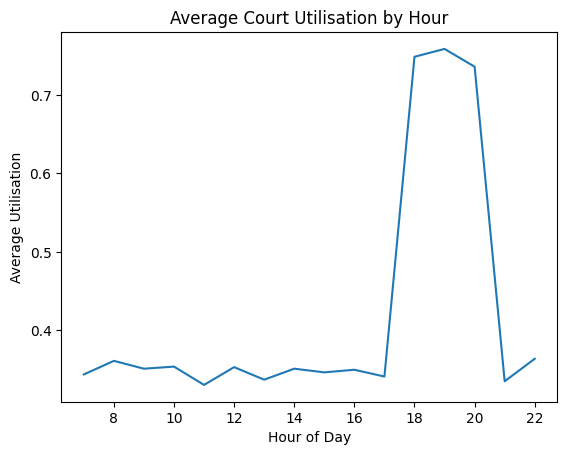

In [171]:
# average utilisation (y) against hour (x)

# for each hour, look at the mean utilisation (per hour)
df.groupby("hour")["utilisation"].mean().plot(kind="line")

import matplotlib.pyplot as plt
plt.ylabel("Average Utilisation")
plt.xlabel("Hour of Day")
plt.title("Average Court Utilisation by Hour")

### Utilisation vs Hour
- This line plot shows the average court utilisation across different hours of the day.
- Utilisation increases significantly in the evening hours (18-21), indicating peak demand after working hours, while morning and early afternoon slots consistently show lower utilisation.
- Hence, there is higher booking risk during evening periods.

#2 Bar chart for risk level distribution 

Text(0.5, 1.0, 'Risk level distribution')

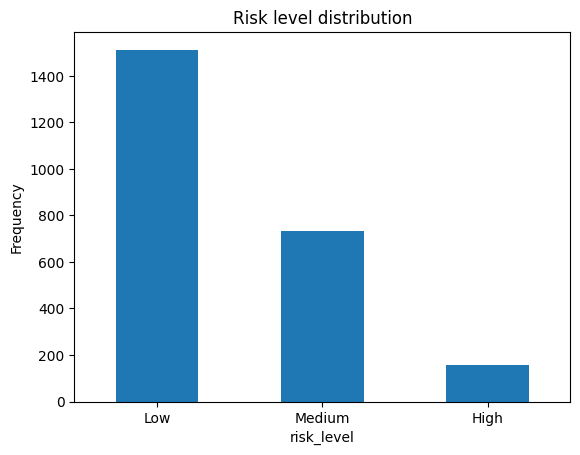

In [172]:
# frequency against risk level (low, medium, high)
df["risk_level"].value_counts().plot(kind="bar")

plt.ylabel("Frequency")
plt.xticks(rotation=0) # horizontal labels
plt.title("Risk level distribution")

### Risk Score Distribution
- This bar chart shows the distribution of booking risk levels across all venue–time combinations.
- Most time slots have low-risk, a notable proportion of time slots have medium-risk and the least time slots have high-risk.
- Low risk slots are mainly concentrated in off-peak hours.
- Hence, while bookings are generally feasible, users need to be more selective during peak periods to avoid high-risk slots.


#3 Bar chart for venue capacity comparision

Text(0.5, 1.0, 'Total courts for venues')

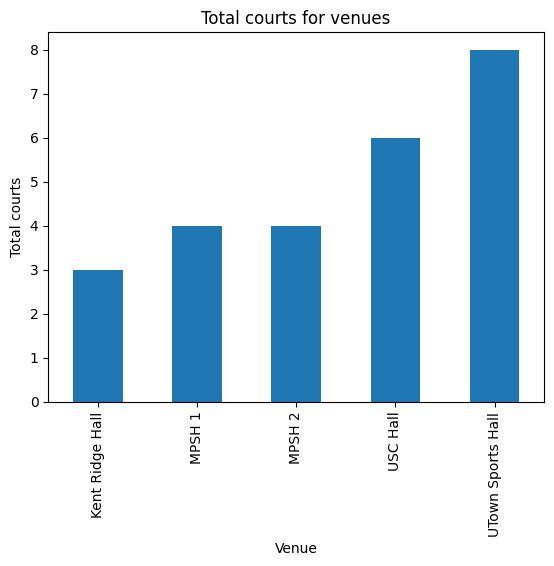

In [173]:
# For each venue, get its total number of courts 
# each venue has many values for total_courts (repeated numbers),
# use .mean() to get a singular value
df.groupby("venue")["total_courts"].mean().plot(kind="bar")
plt.ylabel("Total courts")
plt.xlabel("Venue")
plt.title("Total courts for venues")

### Venue Capacity Comparison
- This bar chart compares the total court capacity across different venues.
- Some venues have higher court capacity, which generally results in lower utilisation and reduced booking risk. (since utilisation = booked_courts / total_courts)
- Venues with fewer courts tend to reach high utilisation more quickly. (because total_courts is smaller)
- Hence, venue choice plays an important role in managing booking risk, beyond just selecting the right time slot.


### Overall Insights

The visualisations show that booking risk is driven by both time-based demand patterns and structural venue capacity.

Evening hours consistently carry higher risk due to increased utilisation, while venues with higher court capacity offer more resilient availability.

By considering both time and venue choice, users can significantly reduce the likelihood of unsuccessful bookings.


### Practical Implications

Users aiming to minimise booking risk should prioritise:
- Off-peak hours where utilisation is consistently lower
- Venues with higher court capacity
- Medium-risk slots when High-risk slots dominate peak periods
